<img src="./assets/intro_banner.png" width="500" height="auto" />

*Content authors: Philip Weinberg, Luís Martinez, Pedro Lopes*

We now continue our journey diving deeper into the subtleties of generating solutions to problems with actual quantum hardware. We will extend the work so far from adiabatic sweeps on small to large regular lattices, provide guidance on how to retrieve and analyze quantum data, and showcase some example scripts that extract data from Aquila and feed it into a plotting pipeline for studying a given problem. Throughout, we will stick to the same checkeboards states of the previous chapter, for the sake of concreteness.

### Learning Objectives

#### By the end of the session, you will be able to:

- Deploy adiabatic algorithms on quantum hardware ensuring a pipeline for data retrieval
- Analyze quantum hardware data judging quality of solutions

## 1. Scale up your Quantum job

In the previous section we discussed how to adiabatically prepare ordered phases in tightly packed arrays of Rydberg atoms in 2D. If you want to extract certain statistical information about the ordered phases you are studying, or information about the phase transition when preparing a ordered phase, you will likely want to scale the system sizes which you are analyzing. While these dynamical processes can be simulated with classical platforms, that won't happen without a degree of difficulty. At best, you will need to develop expertise in time-dependent tensor networks methods. For some more complicated dynamical scenarios, you may not be able to simulate the process at large scales classically at all. This is when learning how to operate quantum hardware and doing experiments directly becomes imperative.

In this section we will discuss how to use Bloqade to scale up your quantum job to run on real quantum hardware, manage your jobs and analyze your results. There are plenty of subtleties in using a cloud based device but we have your back!

### 1a. Before you start using Hardware

Using a cloud-based quantum device requires a few extra steps to get started. Presently, there are two ways of accessing Aquila, QuEra's analog quantum computer, on the cloud: either on Amazon Braket, or via qBraid's platform (which ultimately utilizes the Amazon Braket service). For regular Braket users you will need to make sure to sign in and authenticate your device to have access to braket if you are running your jobs locally, see [here](https://docs.aws.amazon.com/signin/latest/userguide/what-is-sign-in.html) for more details on how to set up your AWS accounts. Braket accounts for jobs by distinguishing "tasks" - different calls for a problem to be solved, typically each with distinct Hamiltonians - and "shots" - the repetition number of a given task to build statistics. Tasks and jobs are accounted and [priced differently](https://aws.amazon.com/braket/pricing/).

To setup a Bloqade notebook or script to submit jobs from your AWS account, all you will have to do is to initialize your AWS access key ID details as environmental variables as:


```
%env AWS_ACCESS_KEY_ID = ...
%env AWS_SECRET_ACCESS_KEY = ... 
%env AWS_SESSION_TOKEN = ...
%env AWS_DEFAULT_REGION = us-east-1
```
at the beginning of your notebook, or

```
import os
os.environ["AWS_ACCESS_KEY_ID"] = "..."
os.environ["AWS_SECRET_ACCESS_KEY"] = "..."
os.environ["AWS_SESSION_TOKEN"] = "..."
os.environ["AWS_DEFAULT_REGION"] = "us-east-1"
```
on your python script.

Once you have authenticated your device/envirionment you should be able to submit tasks, retrieve results and access hardware capabilities.

> NOTE: due to security reasons, your AWS credentials must be refreshed every little while. While we will be accessing Aquila asynchronously to submit jobs to its queue, remember that you will need to routinely renew your credentials if fetching is done a long time after submission. Also, when submitting large batches, note that the submission process itself may take long and you must be careful with refreshing your credentials.

For Qbraid users, authentication is handled automatically by activating a virtual environment, see [here](https://docs.qbraid.com/projects/lab/en/latest/lab/quantum_jobs.html) for more details. You won't have to worry about refreshing credentials or anything.

### 1b. Scaling up your Quantum job

Now that we covered formal stuff, we can get to the real business. The 2D square lattice checkerboard phase of our previous chapter will serve as our testing base.

Going back to the previous chapter, notice that we set `L=3` to simulate a 3x3 array of Rydberg atoms. If we are interested in studying the physical properties of the checkerboard "phase", a humble goal, this system is likely too small. The checkerboard phase is a _bulk_ property of a system. That means that we can only confidently talk about a "phase" of a material if we are looking far from the boundaries of the system. In a 3x3 system, 1 atom is in the bulk of the square lattice, and 8 are on the boundary. We can hardly talk about bulk properties of the system and surface effects will really dominate phenomenology.

FreeResponseQuestion("exercise31b")

So we will have to prepare phases with much more qubits. While some of this can easily be done classically, realism can be lost, and a certain degree of specialization with high-performance simulation methods will be needed. While those are good, and in fact complementary, we will just aim at doing proper a proper calculation with a real quantum computer - and face all questions regarding errors and loss of fidelities of all kinds, from dynamics to measurement to atom placing. We can increase this to simulate a larger array of atoms on the hardware. After all, that is why they were invented.

That means Aquila can operate up to 256 qubits in a single task. Let's use this power to simulate an adiabatically prepared 11x11 square checkerboard phase with Rydberg atoms. By construction, we can achieve that by simply taking our previous example and setting `L=11`. Revisiting the parameter setting, we have:

In [1]:
# Section imports
from bloqade.atom_arrangement import Square
import numpy as np
from bokeh.io import output_notebook
output_notebook()

# Change the lattice spacing to vary the atom separation a, and thus also Rb/a
delta_end=2*np.pi*6.8 #final detuning
omega_max=2*np.pi*2.5 #max Rabi amplitude
lattice_spacing = 7.0 #size of edges of square lattice


C6 = 2*np.pi * 862690;
Rb = (C6 / (omega_max) )** (1/6) # R_B during bulk of protocol
print("Rb/a: ",Rb/lattice_spacing)

print("Delta/Omega: ", delta_end/omega_max)

Loading BokehJS ...

Rb/a:  1.1964312624669644
Delta/Omega:  2.72


If it helps, revisit Chapter 2 Sec. 3a to see again how these parameters fix a Hamiltonian well within the checkerboard phase. Also, if you forgot some of the specific hardware constraints, or would like to organize your code and scales according to Aquila's dynamic range, you can us Bloqade's handy `get_capabilities` function to help you. For example:

In [2]:
from bloqade import get_capabilities
from decimal import Decimal

max_rabi = get_capabilities().capabilities.rydberg.global_.rabi_frequency_max
print(max_rabi/Decimal(2*np.pi)) # our standard maximum value for Rabi amplitude in MHz

2.514648100851946403173667416


Note that working with `Decimal` numbers is recommended for Bloqade to maximize precision. For a complete list of what fields are availible see the Bloqade documentation [here](https://bloqade.quera.com/latest/reference/hardware-capabilities/)

### 1c. Defining the Bloqade Program

Let's do the same adiabatic protocol from the previous chapter, but build two different geometries, small and large, so we can draw comparisons. Let's do so via some Bloqade tricks:

In [3]:
sweep_time = 2.4 #time length of the protocol 
rabi_amplitude_values = [0.0, omega_max, omega_max, 0.0]
rabi_detuning_values = [-delta_end, -delta_end, delta_end, delta_end]
durations = [0.8, sweep_time, 0.8]


geometries = {
    1: Square(3, lattice_spacing=lattice_spacing),
    2: Square(11, lattice_spacing=lattice_spacing),
}

prog_list = {
    idx:(geometry.rydberg.rabi.amplitude.uniform.piecewise_linear(durations, rabi_amplitude_values)
    .detuning.uniform.piecewise_linear(durations, rabi_detuning_values) )for idx, geometry in geometries.items()
}

So there we go. We have a list of programs, one for each geometry of interest for comparison purposes.

In [4]:
prog_list[1].parse_register().show()
prog_list[2].parse_register().show()

### 1d. Submission to Hardware

Submitting the program to hardware is just as simple as running on the emulator. The only difference is that the hardware job is submitted to a queue and may take some time to run. Accordingly, a best practice is to call a run using the `run_async` function instead of `run`. The main importance of doing that is that the `run_async` method will return a results object that will contain metadata about about the job(s) that have been submitted to Aquila. This way, you will be able to easily retrieve the corresponding data without mixing files, but also retrieve details about the specific program you requested to run in a specific submission, in case you by chance forget something or mixes file names.

So let's compare the different job submission processes for classical emulation and for Aquila:

_Classical:_
```python
emulation_3x3_10shots_results=prog_list[1].bloqade.python().run(shots=10)
```
_Aquila:_
```python
Aquila_3x3_10shots_results = prog_list[1].braket.aquila().run_async(shots=10)
bloqade.save(Aquila_3x3_10shots_results, "cherkerboard_3x3_10shots.json")
```

To run a job for a 11x11 lattice, all that you have to change is ` prog_list[1]` -> ` prog_list[2]`. But mind you: if you try running a classical emulation of this on blockade, you will likely freeze your computer.

The main differences are:
* `.bloqade.python()` -> `.braket.aquila()`, i.e., the Bloqade service is exchanged for the AWS Braket service, and the Python backend is substituted by the Aquila backend
* `.run` -> `.run_async`, for the reasons explained above
* When running on hardware (as well as when doing large simulations), it is imperative to save your data, remembering to use file names that clearly identify the corresponding task. This is done using Bloqade's  `save`. The saved file with the results can be loaded later using the `load` function. The corresponding object contains a list of all the jobs that have been submitted to the hardware along with the task ID which is used to retrieve the results from the hardware.


> make sure to use best practices for simplicity and clarity when naming your files. You should really follow the same standards you would follow when submitting jobs to a regular high-performance computer cluster, if you ever used one. Clear identification will help you retrieving and analyzing data. For serious experimentation and research, this effective management is crucial for success. Also note that batches take time being submitted to Aquila. A rule of thumb to better manage that is to keep batch sizes to 20-50  tasks.

### 1e. Parallelizing registers

The task submission examples in sub-section 1c correspond to very few shots, to make sure no one is caught with pricey quantum computing runs. In current prices the 1 task and 10 shots would amount to 40 cents on Amazon Braket. But these few shots also limit our statistics. If you go back to Chapter 2 Section 3, you will notice that even our simulations for the 3x3 system were made with 100 shots, which is a better start for accounting to quantum statistics, noise, etc.

Now, 3x3 systems are small enough that they can be parallelized inside Aquila's field of view, effectively increasing our throughput. While one could define parallelized registers by hand, let's use a final Bloqade trick, as the package can help you achieve parallelization and data analysis much more easily.

To parallelize with Bloqade, all we have to do is to figure out what is the distance we'd like between patches. For us, we will use

In [5]:
inter_patch=9.87 #um

and to submit a parallelized job, all we need to change in our call is to write

```python
Aquila_3x3_10shots_9parallelized_results = prog_list[1].parallelize(inter_patch).braket.aquila().run_async(shots=10)
save(Aquila_3x3_10shots_9parallelized_results, "cherkerboard_3x3_10shots_9parallelized.json")
```
That is, incude the `parallelize(D)` method to the program before the choice of service, with `D` being the safety distance between patches in a given program (which is always a function of other energetics such as the Rabi drive).

FreeResponseQuestion("exercise31e")

We will see, in what follows, what are the potential consequences of parallelization, what are good practices to setting up distances, and how to analyze the corresponding data.

## _Submission checklist_

Many details must be chosen correctly to ensure a quantum job does what we want. So here goes a checklist to aid verifying things before committing to spend money on data:

* Is the geometry setup correct? Check:
    * number of atoms
    * correct interatomic distance scales
    * correct shape of the register

* Are the waveform settings correct? Check:
    * shape and maximum values of Rabi drive
    * shape and maximum values of detuning drive
    * general total length of the program

* Are the quantum statistics settings adequate? Check:
    * number of shots/repetitions
    * if parallelization is being used and, if so, if the correct distance between patches was chosen
    
* Are the general submission details correct? Check:
    * if appropriately named files being created to save the metadata and actual calculation results
    * in case batching multiple tasks, if all of the items above are correct for every single task being automatized


## 2. Data analysis

In this section we will focus on retrieving data, and the different analysis processes and functions we can use to obtain information and draw conclusions from it. We will be using results from our simulations, as well as data pre-generated on Aquila, so we don't have to worry about costs for experiments.

We have run 4 experiments on Aquila, which we will compare with 2 classical emulations as we analyze the data. Namely, we have:

_Aquila_
* checkerboard_3x3_Aquila_10shots 
* checkerboard_3x3_Aquila_100shots 
* checkerboard_3x3_Aquila_10shots_9parallelized 
* checkerboard_11x11_Aquila_100shots

We have chosen names for our jobs that are descriptive, as we should. Our classical simulations are

_Classical_
* checkerboard_3x3_emulation_10shots
* checkerboard_3x3_emulation_100shots

Get ready for a lot of data analysis! We will cover some methodologies to extract the information and show sample functions to plot and study those.

### 2a. Synchronizing and controling tasks in your `results` object with the cloud

The `results` object (`Aquila_3x3_results` above) has some methods that allows you to control when and how to query the cloud for obtaining both the status of your jobs as well as the actual results. You also have the ability to cancel jobs that are still in the queue or filter out jobs based on their status. 

Here is a list of useful methods and what they do:

- `results.fetch()` - Your most trustworthy data retrieval method. Does a single query to the cloud to get the status of all jobs, downloading the results of any jobs that have completed.
- `results.cancel()` - Cancels all jobs that are still in the queue.
- `results.pull()` - Blocks execution until all jobs have terminated either successfully or not, and downloads the results of all jobs that have completed successfully.

Since the data on this chapter is all pre-generated, we won't need to use these. We will just load the data below. In a general scenario, wherever were the `results` variable utilised to save the `.json` results file, we would just have to run one of the commands above to get the data from the cloud (again, most often `.fetch()`).

### 2b. Retrieving your data and health checks

So let's start by running a couple of useful simulations, and loading our pre-generated data. We have 

In [6]:
from bloqade import load

# redefining the general program for this section
sweep_time = 2.4 #time length of the protocol 
rabi_amplitude_values = [0.0, omega_max, omega_max, 0.0]
rabi_detuning_values = [-delta_end, -delta_end, delta_end, delta_end]
durations = [0.8, sweep_time, 0.8]


geometries = {
    1: Square(3, lattice_spacing=lattice_spacing),
    2: Square(11, lattice_spacing=lattice_spacing),
}

prog_list = {
    idx:(geometry.rydberg.rabi.amplitude.uniform.piecewise_linear(durations, rabi_amplitude_values)
    .detuning.uniform.piecewise_linear(durations, rabi_detuning_values) )for idx, geometry in geometries.items()
}


# Classical emulation. These are simple enough we just generate live
emulation_3x3_10shots_results=prog_list[1].bloqade.python().run(shots=10)
emulation_3x3_100shots_results=prog_list[1].bloqade.python().run(shots=100)

# Aquila. Pre-generated and stashed into our /data folder
Aquila_3x3_10shots_results=load("data/checkerboard_3x3_10shots_2p6usramp.json")
Aquila_3x3_10shots_9parallelized_results=load("data/checkerboard_3x3_10shots_9parallelized_2p6usramp.json")
Aquila_3x3_100shots_results=load("data/checkerboard_3x3_100shots_2p6usramp.json")
Aquila_11x11_10shots_results=load("data/checkerboard_11x11_10shots_2p6usramp.json")
Aquila_11x11_100shots_results=load("data/checkerboard_11x11_100shots_2p6usramp.json")

Great! We got our data! Now how does an expert look at quantum data once it comes back from Aquila? Before we are too trigger-happy and analyzing results, here are a few health checks we should consider doing on the retrieved jobs from the quantum computer.

Health checks:
- Loading percentage: atoms are expected to be placed in a desired spot with 0.99 likelihood. But for a register with $N$ atoms this becomes $0.99^N$. Checking if this is respected throughout your jobs will help you estimate the general quality of your data.
- Failed jobs in batch. When submitting multiple tasks in a batch, if one or two fail, that can be an indication that some machine failure could have occurred and damaged your whole job. While rails are in place to control that in the Aquila service, it is a healthy habit to double check.
- If `parallelize()` was used, did we get the expected number of register repetitions? Mistakes in the submission process or determining the inter-register natural distance can affect the quality or extent of multiplexing achieved.
- If similar, or equal, jobs are submitted at different dates, it is worth checking the general relative quality of the data, as parameter drifts may affect the validity of seemingly equivalent results. While, again, rails exist to protect users from this, checking for it can be a healthy habit.

For us, all the jobs above were submitted closely in time. No drifting is expected. Let's do the other tests on a couple of our data files to see how system size and repetition variation can change these checks.

So the first basic tests include just checking the status of a given task, which will always remind us how many shots where taken in it. We can also find out which tasks in a batch could have failed using `get_failed_tasks()`, which in our case points to a single task which actually was successful, so it returns an empty result.

In [7]:
# health-check tests
print(Aquila_3x3_10shots_results.tasks_metric())

# filter_failed_tasks
print(Aquila_3x3_10shots_results.get_failed_tasks())


                                             task ID     status  shots
0  arn:aws:braket:us-east-1:592242689881:quantum-...  Completed     10
Empty DataFrame
Columns: [task ID, status, shots]
Index: []


Using `remove_failed_tasks()` would then remove the bad results from a batch, for example. More details of these different functions can be found on [Bloqade's documentation](https://bloqade.quera.com/latest/reference/bloqade/task/batch/?h=get_failed_tasks#bloqade.task.batch.RemoteBatch.remove_failed_tasks).

Next, let's look at the loading percentage. That can be obtained by inspecting the `dataframe` of a report:

In [8]:
Aquila_3x3_10shots_results.report().dataframe

0  1  2  3  4  5  6  7  8
task_number cluster perfect_sorting pre_sequence                           
0           (0, 0)  111111111       111111111     0  1  0  1  0  1  0  1  0
                                    111111111     0  1  0  1  0  1  1  1  0
                                    111111111     0  1  0  1  1  1  0  1  0
                                    111111111     0  1  0  1  0  1  0  1  0
                                    111111111     0  1  0  1  0  1  0  1  0
                                    111111111     0  1  0  1  1  1  0  1  0
                                    111111111     0  1  0  1  0  1  0  1  0
                                    111111111     0  1  0  1  0  1  0  1  0
                                    111111111     0  1  0  1  0  1  1  1  1
                                    111111111     0  1  0  1  0  1  0  1  0

Here task_number identifies the index of a given task in a batch, perfect_sorting indicates what is the initial state we were interested in (for all practical terms, it will always be a `111...111` state, i.e. with all atoms in the ground state). Now pre_sequence is where information starts to get interesting. This contains the measurements post-sorting of atoms, but before the quantum computing sequence, the Hamiltonian evolution, is applied. It allows us to know if our sorting was correct to begin with or not.

Since our system is small, we don't seem to have had any trouble with any of our shots. Yet, if we look at our larger system results...



In [9]:
Aquila_11x11_10shots_results.report().dataframe

0    \
task_number cluster perfect_sorting                                    pre_sequence                                              
0           (0, 0)  11111111111111111111111111111111111111111111111... 11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    0   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    0   
                                                                       11111111111111111111111111111111111111111111111...    0   
                                                                       11111111111111111111111111111111111111111111111...    0   
                                                                       11110111111111111111111111111111111111111111111...    0   

                                                                                                                           1    \
task_number cluster perfect_sorting                                    pre_sequence                                              
0           (0, 0)  11111111111111111111111111111111111111111111111... 11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    0   
                                                                       11111111111111111111111111111111111111111111111...    0   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11110111111111111111111111111111111111111111111...    1   

                                                                                                                           2    \
task_number cluster perfect_sorting                                    pre_sequence                                              
0           (0, 0)  11111111111111111111111111111111111111111111111... 11111111111111111111111111111111111111111111111...    0   
                                                                       11111111111111111111111111111111111111111111111...    0   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111111111111111111111111111111...    1   
                                                                       11111111111111111111

Even with as few as 10 shots, we see some pre_sequence atoms that were not exactly what we were expecting, as indicated by the '0' entries. Since these are done before the evolution, these really do not correspond to atoms that were initialized into a Rydberg state by chance. Rather, the atom was just not there to begin with! Sometimes, this can be ok, and when averaging quantities over many shots, this is often perfectly fine. But depending on your application, this is not fine at all! So mind that when considering the health of your data.

A way of computing the ratio of imperfect bitstrings could be:

In [10]:
pre_sequence_bitstrings = Aquila_11x11_100shots_results.report().dataframe.index.get_level_values("pre_sequence")

# Count non-perfect bitstrings
non_perfect_count = sum(1 for bitstring in pre_sequence_bitstrings if '0' in bitstring)

# Total number of bitstrings
total_bitstrings = len(pre_sequence_bitstrings)

# Ratio of non-perfect bitstrings to total bitstrings
print(non_perfect_count / total_bitstrings)

0.36


Where we are using the data from 100 shots so that it is statistically more sound. Note that $0.99^{121}\sim 0.30$, so sorting here is a bit better than 99%!

### 2c. Massaging and post-processing

Now we know everything is correct, we can start analyzing things out, and processing that data to see how it affects our understanding of the system at hand.

#### i) Sampling rates

We have already learned to `.report().show()` to get general information and a data analysis on our emulation results, and these commands also work for data coming from hardware. But we should be able to manipulate our data more freely, so let's create our own analysis pipeline. First, notice that we can extract the bitstrings corresponding to our measurements, and their corresponding frequencies using `.counts()` on our report:

In [11]:
emulation_3x3_100shots_results.report().counts()[0]

OrderedDict([('010101010', 99), ('010101110', 1)])

We can then extract the information from these counts by the `.keys()` and `values()` of the dictionary. So here goes a standard python function that ingests the dictionaries and plots corresponding histograms:

In [12]:
def plot_bitstring_histograms(dict_collection, labels):
    """
    Plots histograms for a collection of ordered dictionaries containing bit strings and their frequencies side by side.

    Parameters:
    dict_collection (list of OrderedDict): List of ordered dictionaries with bit strings as keys and frequencies as values.
    labels (list of str): List of labels for each dictionary's plot.
    """
    num_dicts = len(dict_collection)
    
    # Determine the figure size based on the number of plots
    fig, axes = plt.subplots(1, num_dicts, figsize=(15, 6), constrained_layout=True)
    
    if num_dicts == 1:
        axes = [axes]  # Ensure axes is always a list for consistency
    
    for i, (bitstring_dict, ax) in enumerate(zip(dict_collection, axes)):
        # Extract keys and values
        bitstrings = list(bitstring_dict.keys())
        frequencies = list(bitstring_dict.values())

        # Check if any bitstring is longer than 12 bits
        if any(len(bitstring) > 12 for bitstring in bitstrings):
            # Convert bitstrings to integers if length > 12
            xticks = [int(bitstring, 2) for bitstring in bitstrings]
        else:
            xticks = bitstrings


        # Plotting the histogram
        ax.bar(bitstrings, frequencies, color='#FF8C00')

        # Adding titles and labels
        ax.set_title(labels[i])
        ax.set_xlabel('Bit Strings')
        ax.set_ylabel('Frequency')

        # Rotate x-axis labels for better readability
        ax.set_xticks(range(len(xticks)))
        ax.set_xticklabels(xticks, rotation=90 if len(bitstrings) > 5 else 45, ha='right')
        
        # Handle dense bars by reducing font size
        if len(bitstrings) > 10:
            for tick in ax.get_xticklabels():
                tick.set_fontsize(8)
    
    # Display the plot
    plt.show()

Now let's collect the data and look at the different bitstring histograms side-by-side. 

What do we observe? What do we learn?

In [13]:
# Collection of dictionaries
emulation_collection = [emulation_3x3_10shots_results.report().counts()[0],
                   emulation_3x3_100shots_results.report().counts()[0],
                   ]

# Labels for the dictionaries
emulation_labels = ['Emulation 3x3 10 shots',
          'Emulation 3x3 100 shots', 
          ]

# Generate histograms
plot_bitstring_histograms(emulation_collection,emulation_labels)

NameError: name 'plt' is not defined

Let's start with analyzing these emulation results. Clearly, we are quite successful at preparing a specific state `010101010`, which as we will check below, is indeed the expected checkerboard pattern. But we should not be overconfident. We are not preparing a perfect product state. The adiabatic protocol is constrained by the speed at which we ramp our waveforms and this reflects on eventual imperfect final state preparation. Typically, running more shots reveals that, although in simplified instances like this 3x3 square lattice, at times, 100 simulated shots will still return a "perfect preparation".

Now let's move to real quantum data.

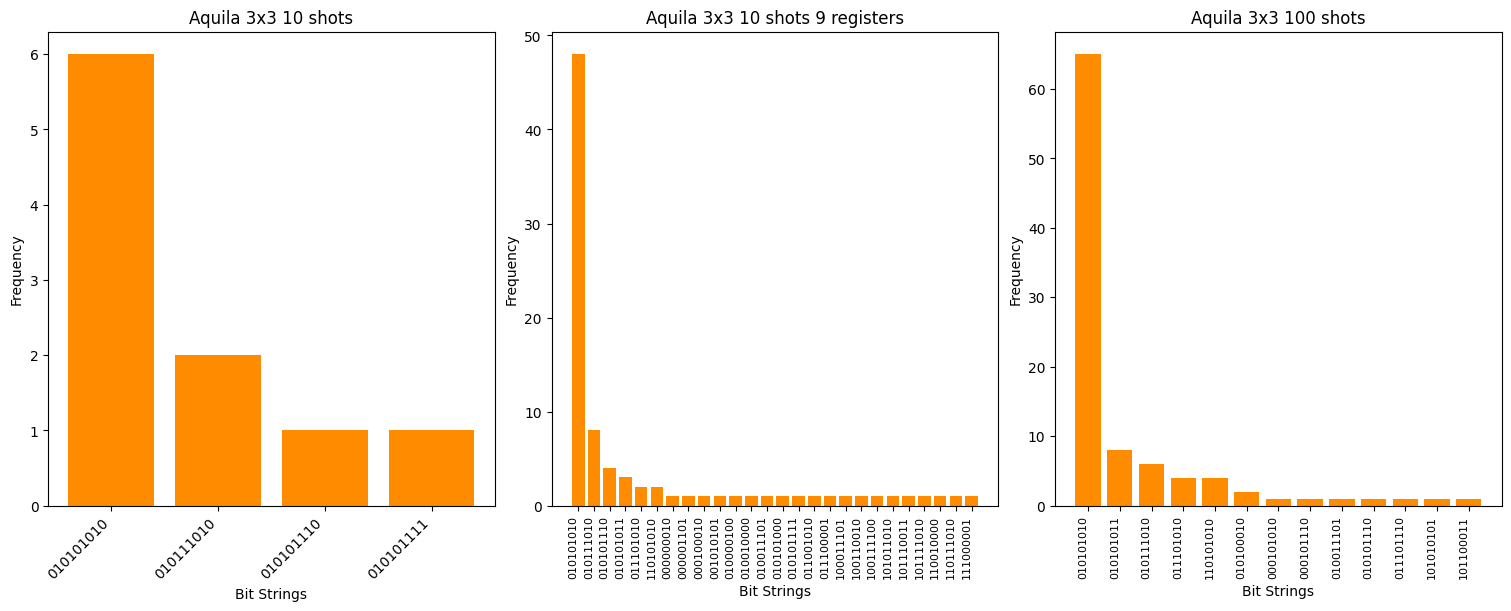

In [19]:
# Collection of dictionaries
aquila_collection = [
                   Aquila_3x3_10shots_results.report().counts()[0],
                   Aquila_3x3_10shots_9parallelized_results.report().counts()[0],
                   Aquila_3x3_100shots_results.report().counts()[0]
                   ]

# Labels for the dictionaries
aquila_labels = [
          'Aquila 3x3 10 shots', 
          'Aquila 3x3 10 shots 9 registers',
          'Aquila 3x3 100 shots'
          ]

# Generate histograms
plot_bitstring_histograms(aquila_collection,aquila_labels)

As we move to Aquila, we see that even at 10 shots, what we thought to be a high-performing adiabatic algorithm in theory, will start showcasing effects from non-adiabaticity, decoherence, and general different sources of noise. Now, 10 shots is not great statistics. Remember that we have 9 qubits and thus a $2^9=512$-dimensional Hilbert space. Furthermore, when evaluating (like $\hat{n}_i$) observables, as we do below, a general rule is that standard error of the mean values are estimated at a $1/\sqrt{N_s}$ rate, where $N_s$ is the number of shots. Good numbers to remember are $N_s=10 \to 10\%$ precision, $N_s=100 \to 3\%$ precision, and $N_s=1000 \to 1\%$ precision in our average estimations.

On Aquila, getting more shots costs more, so there are two alternatives at this point. Since our systems are small, we can try to multiplex our calculations using `parallelize()`, in which case we an get the ~100 shots worth of measurements without actually increasing the cost of our simulation. Or we can just pay what it takes. Above, we have results from both scenarios. 

As we see, parallelization does allow us to build more statistics while keeping the correct checkerboards pattern as the main prepared state. But performance has degraded quite a lot. The main reason for that is that we created a really dense system of 3x3 lattice patches, with the ratio of inter-patch distance over lattice constant $9.87/a\approx 1.59$, comparable with the second-neighbor distance of $\sqrt{2}$ on the square lattice. So patches are not interacting that weakly with each other. An inter-patch interaction strength 5x-10x weaker than the strongest desired interaction would be a safer choice. 

The best way of seeing what `parallelize()` did to the register in your job remains to just `show` the report


In [20]:
Aquila_3x3_10shots_9parallelized_results.report().show()

0.0 64.32 0.0 64.32


From the register middle diagram, we can visually intuit that indeed the 3x3 patches are too close to each other. Paying the sampling cost, and running a 100 shots on a single 3x3 patch returns much more confident results. Above it all, doing the latter shows that the state-preparation fidelity of our protocol is actually around $65\%$, better than our estimate with only 10 shots.

Let's now analyze how sampling affects our precision in estimating mean values of observables, in particular the site-resolved Rydberg densities $\langle n_i \rangle$. 

The first lesson here is that we can re-extract the geometry profiles of our tasks, as well as measurements of the Ryberg excitation density in terms of lists or Pandas data frames

In [21]:
print(Aquila_3x3_100shots_results.report().geos[0].sites)
print(Aquila_3x3_100shots_results.report().rydberg_densities(filter_perfect_filling=False))

[(0.0, 0.0), (0.0, 7e-06), (0.0, 1.4e-05), (7e-06, 0.0), (7e-06, 7e-06), (7e-06, 1.4e-05), (1.4e-05, 0.0), (1.4e-05, 7e-06), (1.4e-05, 1.4e-05)]
                0     1     2     3     4     5     6     7     8
task_number                                                      
0            0.94  0.04  0.93  0.04  0.91  0.05  0.95  0.02  0.89


Here, the index '0' in `.geos` (geometries) labels a task in a batch (we only have one) and returns a list in SI units (mind that!). Computing Rydberg densities and the standard error of the mean values directly is not hard; all one needs to use is the `bitstrings()` method of `report()`:

In [22]:
print(1-np.mean(Aquila_3x3_100shots_results.report().bitstrings(filter_perfect_filling=False)[0],axis=0))
print(np.std(Aquila_3x3_100shots_results.report().bitstrings(filter_perfect_filling=False)[0],axis=0)/np.sqrt(Aquila_3x3_100shots_results.tasks_metric().shots[0]))

[0.94 0.04 0.93 0.04 0.91 0.05 0.95 0.02 0.89]
[0.02374868 0.01959592 0.0255147  0.01959592 0.02861818 0.02179449
 0.02179449 0.014      0.03128898]


> Mind the "$1-$" in the mean value calculation, as 0's and 1's in the bitstrings are reversed with respect to the Rydberg densities. Otherwise, notice that the result is the same, and we can easily obtain the standard deviations as well. (Exercise: why we don't have to worry about "$1-$" for the standard deviation?). Also, note that the standard deviation is not the correct estimator of the uncertainty at which we know our mean values. Rather the standard error of the mean is the correct estimator, and decreases the more we sample the system

While `rydberg_densities()` returns a Pandas data frame, the path using `bitstrings()` requires us to operate directly with numpy arrays. Notably, both `rydberg_densities()` and `bitstrings()` accepts a boolean `filter_perfect_fillings` which can be used to automatically filter instances where sorting was perfect or not. *Disclaimer: `filter_perfect_fillings=True` by default*

> Note that computing the ration of the  `len()` of bit strings with perfect fillings filtered or not is another, perhaps more elegant, way of extracting our sorting fidelity.

So here goes a potentially useful helper functions to scatter plot the Rydberg densities and standard deviations given a set of results files.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def density_analysis(lattice_coords, density_means=None, density_errs=None, labels=None):
    """
    Creates scatter plots with circles at each site of the lattice, colored according to the mean density values,
    and/or a scatter plot for the standard deviations if provided.

    Parameters:
    lattice_coords (np.ndarray): 2D array containing the coordinates of the lattice sites (shape: [n_sites, 2]).
    density_means (list of np.ndarray, optional): List of 1D arrays containing the mean density values for each site of the lattice (each array shape: [n_sites]).
    density_stds (list of np.ndarray, optional): List of 1D arrays containing the standard deviation values for each site of the lattice (each array shape: [n_sites]).
    labels (list of str, optional): List of labels for each plot.
    """
    if density_means is None and density_errs is None:
        raise ValueError("At least one of density_means or density_stds must be provided")

    num_plots = max(len(density_means) if density_means else 0, len(density_errs) if density_errs else 0)
    rows = sum([density_means is not None, density_errs is not None])
    
    fig, axes = plt.subplots(rows, num_plots, figsize=(15, 6*rows), constrained_layout=True, sharey=True, sharex=True)
    
    if rows == 1:
        axes = np.array([axes])  # Ensure axes is always a 2D array for consistency
    elif num_plots == 1:
        axes = np.array([[ax] for ax in axes])  # Ensure each subplot is in a list

    plot_index = 0

    if density_means is not None:
        # Set fixed color scale range for means
        vmin_means, vmax_means = 0, 1
        for i, means in enumerate(density_means):
            ax = axes[plot_index, i] if rows > 1 else axes[0, i]
            x_coords = lattice_coords[:, 0]
            y_coords = lattice_coords[:, 1]

            scatter_means = ax.scatter(x_coords * 10**6, y_coords * 10**6, c=means, cmap='viridis', s=300, edgecolor='k', vmin=vmin_means, vmax=vmax_means)
            ax.set_aspect('equal', 'box')
            ax.set_xlabel('X (um)')
            if i == 0:
                ax.set_ylabel('Y (um)')
            if labels:
                ax.set_title(labels[i] + ' (AVG)')
            else:
                ax.set_title(f'Dataset {i+1} (AVG)')

        cbar_means = fig.colorbar(scatter_means, ax=axes[plot_index, :] if rows > 1 else axes, orientation='vertical', fraction=0.02, pad=0.04)
        cbar_means.set_label(r'$\langle n_i \rangle$')

        plot_index += 1

    if density_errs is not None:
        # Determine the global min and max standard deviations for consistent color scaling
        all_stds = np.concatenate(density_errs)
        vmin_stds = np.min(all_stds)
        vmax_stds = np.max(all_stds)
        for i, stds in enumerate(density_errs):
            ax = axes[plot_index, i] if rows > 1 else axes[0, i]
            x_coords = lattice_coords[:, 0]
            y_coords = lattice_coords[:, 1]

            scatter_errs = ax.scatter(x_coords * 10**6, y_coords * 10**6, c=stds, cmap='coolwarm', s=300, edgecolor='k', vmin=vmin_stds, vmax=vmax_stds)
            ax.set_aspect('equal', 'box')
            ax.set_xlabel('X (um)')
            if i == 0:
                ax.set_ylabel('Y (um)')
            if labels:
                ax.set_title(labels[i] + ' (STD ERR)')
            else:
                ax.set_title(f'Dataset {i+1} (STD ERR)')

        cbar_stds = fig.colorbar(scatter_errs, ax=axes[plot_index, :] if rows > 1 else axes, orientation='vertical', fraction=0.02, pad=0.04)
        cbar_stds.set_label('Standard Error of the Mean')

    # Display the plot
    plt.show()

From this we can generate density plots for the emulation

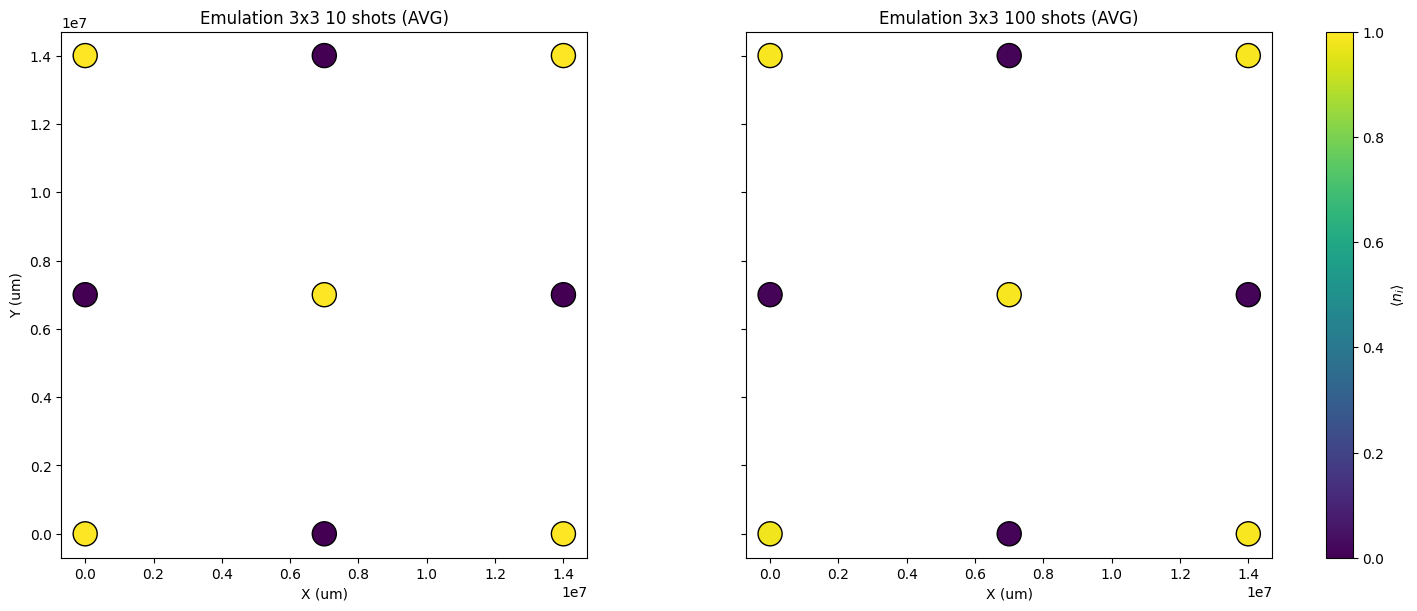

In [24]:
geo3 = np.array(emulation_3x3_10shots_results.report().geos[0].sites)
emu_densities = [
    np.array(emulation_3x3_10shots_results.report().rydberg_densities()),
    np.array(emulation_3x3_100shots_results.report().rydberg_densities()),
    ]

emu_err= [
    np.std(emulation_3x3_10shots_results.report().bitstrings()[0],axis=0)/np.sqrt(Aquila_3x3_10shots_results.report().bitstrings(filter_perfect_filling=False)[0].shape[0]),
    np.std(emulation_3x3_100shots_results.report().bitstrings()[0],axis=0)/np.sqrt(Aquila_3x3_100shots_results.report().bitstrings(filter_perfect_filling=False)[0].shape[0])
]

# Generate the plot
density_analysis(geo3, density_means=emu_densities, labels= emulation_labels)


and Aquila runs,

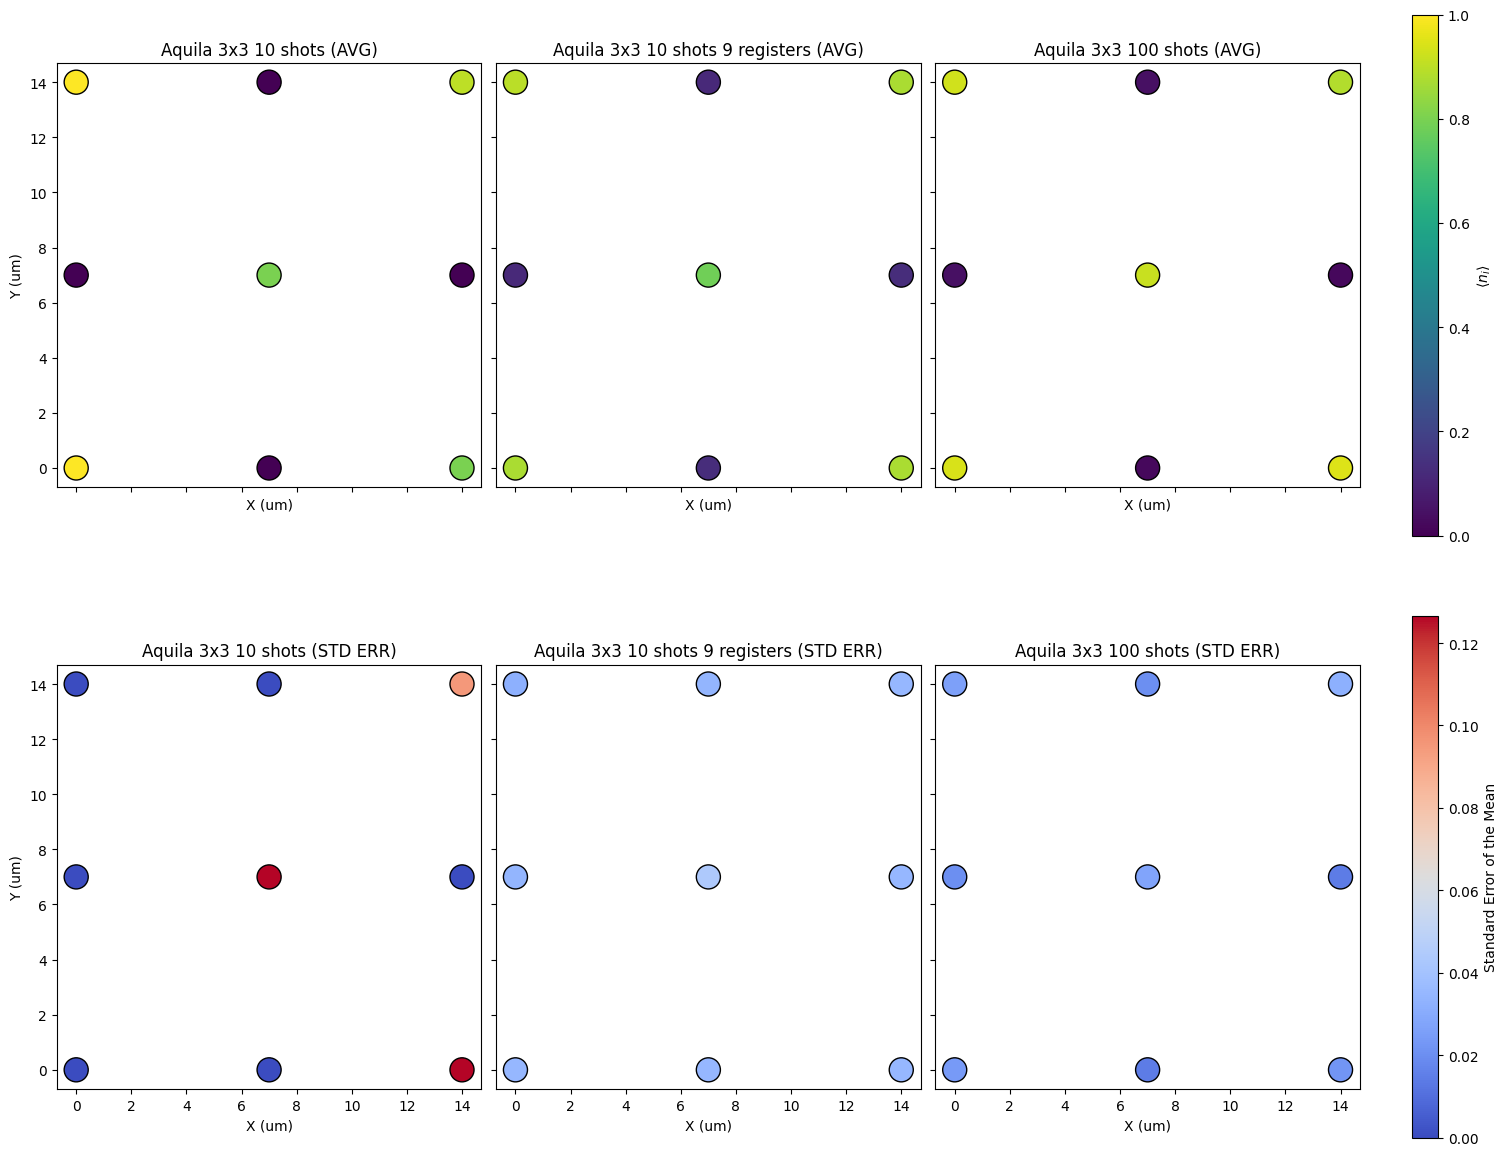

In [25]:
geo3 = np.array(Aquila_3x3_10shots_results.report().geos[0].sites)

aquila_densities = [
    np.array(Aquila_3x3_10shots_results.report().rydberg_densities()),
    np.array(Aquila_3x3_10shots_9parallelized_results.report().rydberg_densities()),
    np.array(Aquila_3x3_100shots_results.report().rydberg_densities())
    ]

aquila_errs= [
    np.std(Aquila_3x3_10shots_results.report().bitstrings()[0],axis=0)/np.sqrt(Aquila_3x3_10shots_results.report().bitstrings(filter_perfect_filling=False)[0].shape[0]),
    np.std(Aquila_3x3_10shots_9parallelized_results.report().bitstrings()[0],axis=0)/np.sqrt(Aquila_3x3_10shots_9parallelized_results.report().bitstrings(filter_perfect_filling=False)[0].shape[0]),
    np.std(Aquila_3x3_100shots_results.report().bitstrings()[0],axis=0)/np.sqrt(Aquila_3x3_100shots_results.report().bitstrings(filter_perfect_filling=False)[0].shape[0])
]

# Generate the plot
density_analysis(geo3, density_means=aquila_densities, density_errs=aquila_errs, labels= aquila_labels)

Here we are also including the standard errors after shot averaging. 

We can see from the above how sampling more data points brings the hardware data closer to the simulation results (notice how the 100 shots plot match the yellow-purple patterns of the emulation). The errors per site are tricky to analyze. 10 shots of our protocol in a 3x3 lattice can be so un-representative that some qubits showcase zero error. But whenever errors are seen and appropriately accounted, one sees that sampling 100 times returns approximately 3 times better precision, the expected $1/\sqrt(10)$ improvement due to sampling 10 times more.

Multiplexing the data is supposed to improve our sampling. If considered literally, our parallelization provides 10x9=90 samples per qubit in the 3x3 lattice. But if the patches are not appropriately separated, that can generate systematic uncertainties, as we saw above. The average values of the Rydberg densities are not as sharply contrasted as expected in the checkerboards phase. In particular, this leads to higher standard deviations which can be seen by multiplying the standard errors by the corresponding square roots of shot numbers. Because the patches are not separated enough here, the honest analysis would be pointing to 10 shots on a clustered problem of interacting 3x3 sublattices and much larger standard errors. Still, the parallelized results display a more uniformized checkerboard pattern than the single 3x3 patch with only 10 samples. 

In all, the lesson is beware. Analyzing the statistics and accuracy of your calculation can become a quite convoluted process. Be criterious and exercise caution!

#### ii) System size

Our first goal when we started this chapter was to scale up our system sizes beyond what would be easily simulated by classical means. While our parallelized system of 3x3 lattice clusters already lies in that regime, it still targeted the analysis of small-sized problems. Now let's go back to our original goal, and analyze the data from our larger lattice runs with 121 qubits.

Let's see what surprises attend us for systems that actually have a bulk. First, let's keep analysis light and just `show()` our report

In [26]:
Aquila_11x11_10shots_results.report().show()
Aquila_11x11_100shots_results.report().show()

0.0 70.0 0.0 70.0


0.0 70.0 0.0 70.0


This is at least interesting, if not elegant. In a Hilbert space of $2^{121}$ dimensions, it should not be surprising that the checkerboard ground state becomes a needle in the haystack. Running 100 shots does not come anywhere near sampling properly that space. But to a certain degree, this was already somewhat the case in th $2^9$-dimensional space.

The key problem is that the smallest gap through our adiabatic protocol gets smaller and smaller as function of our system size. This breaks our adiabaticity and thus our algorithm does not perform as well. Can it be made better? Surely! Within our $4\mu s$, we could definitely make our detuning ramp slower as we are using only $2.4 \mu s$ for our protocol. One could even create optimized pulses. This is the world of state preparation, one of the most important challenges in quantum computing, as well-prepared states are often the starting point of several more complex algorithms.

So if we want to properly analyze these large-scale algorithms, we need to be more careful. Bitstring analysis is not enough. For starters, let's look at the effect of improving statistics at large scales

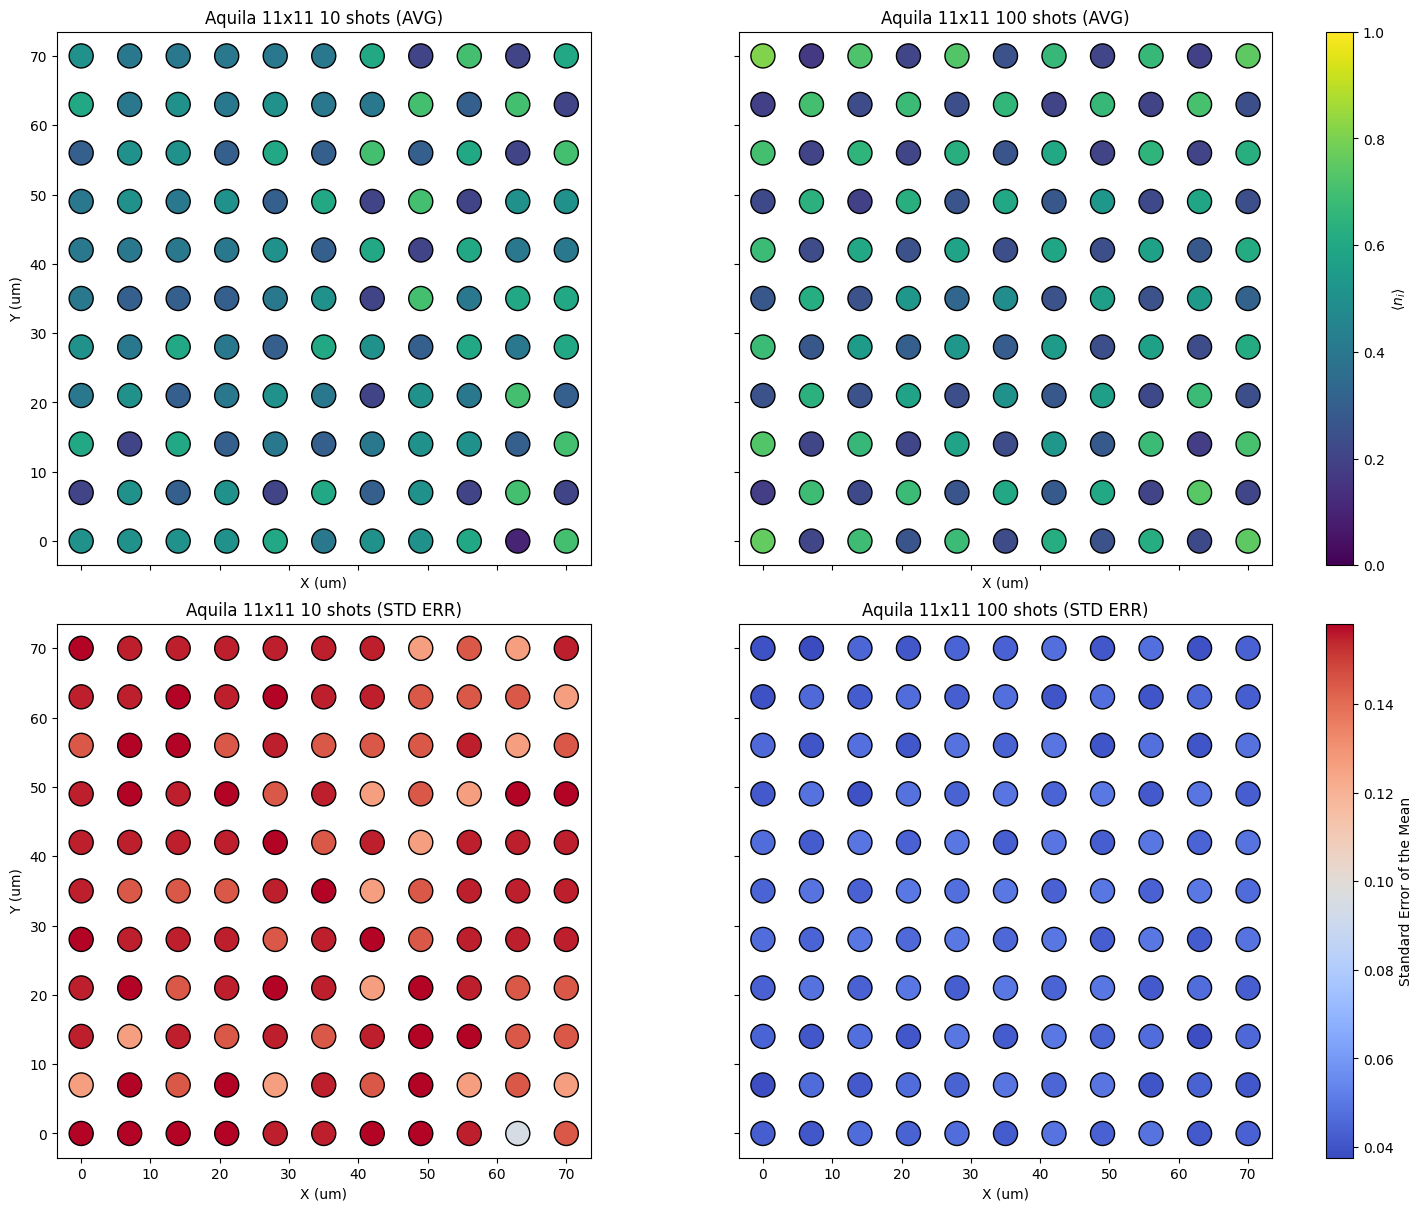

In [27]:
geo121 = np.array(Aquila_11x11_10shots_results.report().geos[0].sites)

densities121 = [
    np.array(Aquila_11x11_10shots_results.report().rydberg_densities(filter_perfect_filling=False))[0],
    np.array(Aquila_11x11_100shots_results.report().rydberg_densities(filter_perfect_filling=False))[0],
    ]

errs121 = [
    np.std(Aquila_11x11_10shots_results.report().bitstrings(filter_perfect_filling=False)[0],axis=0)/np.sqrt(Aquila_11x11_10shots_results.report().bitstrings(filter_perfect_filling=False)[0].shape[0]),
    np.std(Aquila_11x11_100shots_results.report().bitstrings(filter_perfect_filling=False)[0],axis=0)/np.sqrt(Aquila_11x11_100shots_results.report().bitstrings(filter_perfect_filling=False)[0].shape[0])
    ]


large_lattice_labels = [
          'Aquila 11x11 10 shots', 
          'Aquila 11x11 100 shots'
          ]

# Generate the plot
density_analysis(geo121,densities121,errs121,large_lattice_labels)

By inspection, looking at these cases side-by-side showcases that increasing the number of sampling is bringing up the checkerboards pattern. The standard errors are also reducing accordingly. A careful eye will be able to estimate the errors in the order state immediately: scale of colors suggest a variation of about 0.5 in the Rydberg density values, and dividing that by $\sqrt{100}=10$ indicates an standard error of the mean of about 0.05, in accordance with the measured.

Another interesting analysis is to compare the standard deviations while filtering for only perfectly sorted arrays, or not. We realize:

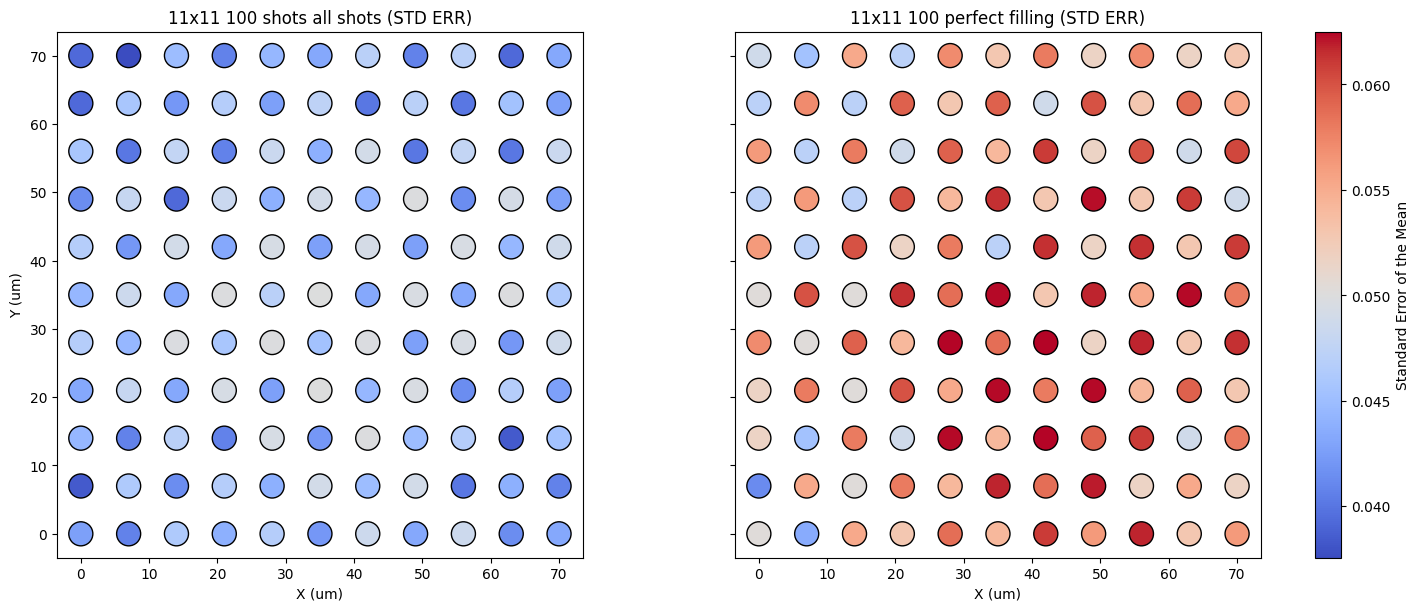

In [28]:
stds_filling_comparison= [
    np.std(Aquila_11x11_100shots_results.report().bitstrings(filter_perfect_filling=False)[0],axis=0)/np.sqrt(len(Aquila_11x11_100shots_results.report().bitstrings(filter_perfect_filling=False)[0])),
    np.std(Aquila_11x11_100shots_results.report().bitstrings(filter_perfect_filling=True)[0],axis=0)/np.sqrt(len(Aquila_11x11_100shots_results.report().bitstrings(filter_perfect_filling=True)[0]))
]


filtering_analysis_labels = [
          '11x11 100 shots all shots', 
          '11x11 100 perfect filling'
          ]

# Generate the plot
density_analysis(geo121, density_errs=stds_filling_comparison, labels= filtering_analysis_labels)

Despite perfect arrays being more representative of the exact problem we want to study, requesting only those arrays reduces the amount of data we generate and increase our standard errors. Since about 50% of our atoms are indeed not expected to be excited in the checkerboards state, and the ordered state is robust to weak disorder, losing a few atoms is not damaging to the state. Overall, results are more realistic and data has more quality in this experiment if we *don't* remove imperfectly sorted arrays.

In [29]:
FreeResponseQuestion("exercise32cii1")

NameError: name 'FreeResponseQuestion' is not defined

We can get further creative. Since the statistics of bitstring sampling is hard to analyze, we can try to collect them by their Hamming distance (the number of bits differing from the expected checkerboards pattern):

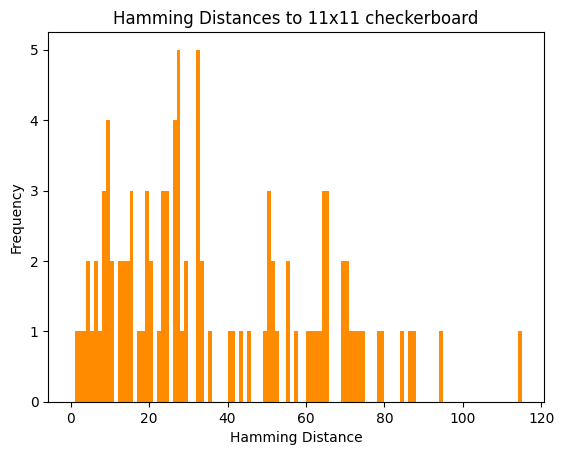

In [30]:
# Define the pattern bitstring
checkerboard_root = '0101010101' * (121 // 9)
checkerboard = checkerboard_root[:121]

# Convert the pattern to a numpy array of integers
checkerboard_array = np.array(list(map(int, checkerboard)))

# Define the array of bitstrings
bitstrings = Aquila_11x11_100shots_results.report().bitstrings(filter_perfect_filling=False)[0]

# Calculate Hamming distances
hamming_distances = np.sum(bitstrings != checkerboard_array, axis=1)

# Plot the histogram 
plt.hist(hamming_distances, bins=range(0, max(hamming_distances)+2), color='#FF8C00', edgecolor='none')
plt.title('Hamming Distances to 11x11 checkerboard')
plt.xlabel('Hamming Distance')
plt.ylabel('Frequency')
plt.show()

By itself, this histogram can be used to evaluate how far from adiabaticity we are, characterize how non-perturbative are the effects of adiabaticity violation, and more. However, it requires us to anticipate what is the (product) state we are trying to prepare so we can compare the Hamming distance.

For ordered systems like the checkerboards pattern, one can get away with analyzing what is often called an order parameter. A quantity that is finite in the patterned system we care, but vanishing otherwise. In the case of the checkerboard phase, a convenient approach to find that is to compute the Fourier transform of our densities (normalized to the full average of the Rydberg excitations in the whole system):

$$ \hat{f}(\vec{k})= \frac{1}{N\times N} \sum_{\vec{x}} e^{i\vec{k}\cdot{\vec{x}}} \langle \hat{n}_{\vec{x}}- \tilde{n} \rangle $$

where $ \tilde{n}=\sum_{\vec{x}}\langle \hat{n}_{\vec{x}} \rangle/(N\times N)$ is the total average of Rydberg excitations in the whole array, and then averaging over the samples to compute the quantum mean of this operator.

To not lose habit, here goes a helper function that extracts the information from Bloqade and does this operation.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_mean_fourier_transforms(positions, bitstrings_list, lattice_constant):
    """
    Computing and plotting the mean Fourier transform of the Rydberg densities
    
    Parameters:
    positions (numpy.ndarray): Array of particle positions in the lattice.
    bitstrings_list (list of numpy.ndarray): List of arrays of sampled bitstrings.
    lattice_constant (float): The lattice constant for the square lattice.
    """
    # Determine the linear size of the lattice and number of positions
    L = int(np.sqrt(positions.shape[0])) * lattice_constant  # Linear size of the lattice
    N = int(np.sqrt(positions.shape[0]))  # Number of positions per dimension

    # Generate wave vectors kx and ky
    kx = np.fft.fftfreq(N, d=lattice_constant) * 2 * np.pi / L
    ky = np.fft.fftfreq(N, d=lattice_constant) * 2 * np.pi / L
    kx, ky = np.meshgrid(kx, ky)

    # Compute the mean of the bitstrings
    all_fourier_transforms = []

    for bitstrings in bitstrings_list:
        bitstrings_global_mean = np.mean(bitstrings)
        bitstrings_centered = bitstrings - bitstrings_global_mean

        for bitstring in bitstrings_centered:
            bitstring_reshaped = bitstring.reshape((N, N))
            ft = np.fft.fft2(bitstring_reshaped)
            all_fourier_transforms.append(ft)

    # Calculate the mean value of all Fourier transforms
    mean_fourier_transform = np.mean(all_fourier_transforms, axis=0)

    # Get the magnitude of the mean Fourier transform for scaling
    all_magnitudes = np.abs(np.fft.fftshift(mean_fourier_transform))

    vmin = np.min(all_magnitudes)
    vmax = np.max(all_magnitudes)

    # Create subplots with GridSpec for precise control
    num_plots = len(bitstrings_list)
    fig = plt.figure(figsize=(5 * num_plots, 5))
    gs = GridSpec(1, num_plots + 1, width_ratios=[1] * num_plots + [0.05])

    axes = []
    for i in range(num_plots):
        axes.append(fig.add_subplot(gs[i]))

    for i, bitstrings in enumerate(bitstrings_list):
        bitstrings_global_mean = np.mean(bitstrings)
        bitstrings_centered = bitstrings - bitstrings_global_mean

        fourier_transforms = []
        for bitstring in bitstrings_centered:
            bitstring_reshaped = bitstring.reshape((N, N))
            ft = np.fft.fft2(bitstring_reshaped)
            fourier_transforms.append(ft)

        mean_fourier_transform = np.mean(fourier_transforms, axis=0)
        mean_fourier_transform_magnitude = np.abs(np.fft.fftshift(mean_fourier_transform))

        ax = axes[i]
        im = ax.imshow(mean_fourier_transform_magnitude, extent=(-np.pi, np.pi, -np.pi, np.pi), cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
        ax.set_title(f'Magnitude of Mean Fourier Transform {i+1}')
        ax.set_xlabel('$k_x$ ($\pi/L$)')
        ax.set_ylabel('$k_y$ ($\pi/L$)')

    # Add a single color bar to the figure
    cbar_ax = fig.add_subplot(gs[-1])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Magnitude')

    plt.tight_layout()
    plt.show()

Now we can obtain:

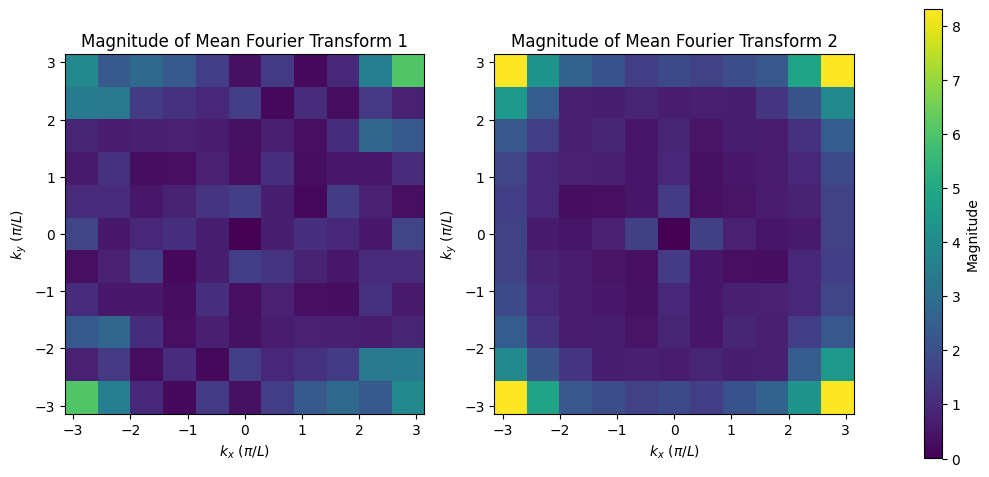

In [32]:
data121 = [
    1-Aquila_11x11_10shots_results.report().bitstrings(filter_perfect_filling=False)[0],
    1-Aquila_11x11_100shots_results.report().bitstrings(filter_perfect_filling=False)[0]
]

plot_mean_fourier_transforms(geo121, data121, lattice_spacing*10**(-6))


What do we see here? What we see is that the checkerboards alternating pattern on every first neighbor is reflected by a pronounced peak at $\vec{k}=(\pi,\pi)$ (this plot should be understood to be periodic by $2\pi$ in both the horizontal and vertical directions). 

This provides a much clearer signal to contrast the patterns from the data with only 10 shots versus 100 shots. For 10 shots, the peak structure at $(\pi,\pi)$ starts to appear, but it is nowhere as clear as the result we obtain after more adequate sampling with 100 shots. Other quantities are able to improve our characterization of the quality of our state preparation, such as the width of the peak, and correlation lengths obtianed from two point correlation functions. 

In [ ]:
FreeResponseQuestion("exercise32cii2")

### 2d. Final words on observable estimations

To wrap up, let's leave some considerations regarding what observables and quantities can be accessed with Aquila. Firstly, notice that only diagonal observables, like strings of $\hat{n}_i$, can be accessed. To meaasure off-diagonal observables, the necessary process is to apply a Hadamard gate on the qubits to be measured, before following with a measurement in the computational basis. While our Rabi term $\Omega$ can be tuned to do something akin to a Hadamard operation in each qubit, the fact that $V_{ij}$ is always present, and is strong in most applications, makes it impossible to do individual and independent $X$ rotations. Even when $V_{ij}$ is weak, the current capabilities for $\Omega$ in Aquila are not enough for any meaningful off-diagonal basis measurement. That does not mean that effects of off-diagonal couplings by the Rabi term on many-body states cannot be studied, but those will generally be complicated.

More subtly, Z-type observables can be accessed, but only those with limited support in the register. These are often known as local. These operators are characterized by strings of few powers of our Rydberg density like $\hat{n}_i$ or $\hat{n}_i\hat{n}_j$. Yet notice that the calculation of mean-values of these operators correspond to tracing over degrees of freedom not part of the operator string. Estimating values for operators with long chains like $\hat{n}_i \hat{n}_j \hat{n}_k \hat{n}_l...$ require, in general, knowledge of a full wavefunction. That, on its turn, require typical $2^N_s$ measurements - remember our discussion of sampling $2^9$- and $2^{121}$-dimensional Hilbert spaces. A rule-of-thumb is that the typical length of bitstrings accessible by measurements will be of order $\sim log_2 N_s$.

For clarity, examples of quantities hard or impossible to obtain with quantum computers - Aquila, in particular - include general probability distributions, the fidelity of preparing arbitrary quantum states, or quantities like entanglement entropies. These quantities require full state tomography and are *not* easy to characterize, even if often used in classical simulation analyses of quantum algorithms.

## Conclusions

This marks the end of our third chapter. Revisiting again our learning objectives, now you are able to
- Deploy adiabatic algorithms on quantum hardware ensuring a pipeline for data retrieval
- Analyze quantum hardware data judging quality of solutions

This chapter closes the initiate content for QuEra's training on neutral-atom quantum computing. Congratulations, you are not a full initiate in neutral atom quantum computing! From now, you may branch to specific topics of interest, including solving combinatorial optimization problems, quantum machine learning, simulating more complex quantum dynamics and phases, and much more! 